In [1]:
import requests
import re
import pandas as pd

In [2]:
from nbdev.showdoc import *

### Example Texts

In [106]:
text = "Autophagy maintains tumour growth through circulating the great arginine."
text1 = "X-rays were negative and physical assessment determined soft tissue damage to the lateral aspect of her ankle. She was initially treated with ice, an ace wrap, crutches and mild pain medications (Tylenol with codeine)"
text2 = "It is a skin disease causing much itchiness. Scratching leads to redness, swelling, cracking, weeping clear fluid, crusting, and scaling."
text3 = "Maybe its a tumour. Maybe take some tylenol. Don't worry I'm not a doctor. I'm Dave"
texts = [text,text1,text2,text3]

### Create Single Text Block from Text That is easily re-separated

In [107]:
coms = pd.DataFrame({'comments':texts}) #create comments df

In [108]:
#| export
def create_text_block(df:pd.DataFrame, #pandas DataFrame containg a column, titled "comments," of text elements.  In this case these are Youtube comments.
                     ):
    '''This function takes a pandas DataFrame with a column titled "comments" that is filled with text strings, ie. from comments.  It adds an index number to each text string and adds '::' at the end for later parsing.  Finally, it returns all text elements combined into a single text block'''
    df.reset_index(inplace=True)
    df.rename(columns = {"index":"idx"},inplace=True)
    df.idx = df.idx.astype(str)
    df['comidx'] = df.idx +': '+df.comments+'::'
    df.comidx = df.comidx.str.lower().str.replace(r'\(|\)',',',regex=True)
    return ' '.join(df.comidx.tolist())

### create_text_block example

In [109]:
text_block = create_text_block(coms); text_block

"0: autophagy maintains tumour growth through circulating the great arginine.:: 1: x-rays were negative and physical assessment determined soft tissue damage to the lateral aspect of her ankle. she was initially treated with ice, an ace wrap, crutches and mild pain medications ,tylenol with codeine,:: 2: it is a skin disease causing much itchiness. scratching leads to redness, swelling, cracking, weeping clear fluid, crusting, and scaling.:: 3: maybe its a tumour. maybe take some tylenol. don't worry i'm not a doctor. i'm dave::"

In [110]:
show_doc(create_text_block)

---

### create_text_block

>      create_text_block (df:pandas.core.frame.DataFrame)

This function takes a pandas DataFrame with a column titled "comments" that is filled with text strings, ie. from comments.  It adds an index number to each text string and adds '::' at the end for later parsing.  Finally, it returns all text elements combined into a single text block

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| df | DataFrame | pandas DataFrame containg a column, titled "comments," of text elements.  In this case these are Youtube comments. |

#### Get Start and End Doc Indecies
> Here we'll use regex to find the text indecies of each doc or comment.  This will tell us which doc or comment is teh parent of each biomedical term returned from BERN2

In [111]:
# get "comment" spans
def get_comment_spans_textblock(text_block:str # single block of text in this structure: `'07 textt ext text. ::'`
                               ):
    '''This function returns a dataframe full of the start, end and span of each text comment/doc in the text_block'''    
    string = text_block
    pattern = r'(\d:.*?)::'
    dfi = pd.DataFrame()
    for o in re.findall(pattern,string):
            match=(re.search(o, string))
            #Getting the start and end index in tuple format using match.span()
            text = o
            start = match.start()
            end = match.end()
            span = match.span()
            dfi = dfi.append({'text':text,'start':start,'end':end,'span':span},ignore_index=True)
    return dfi

In [112]:
show_doc(get_comment_spans_textblock)

---

### get_comment_spans_textblock

>      get_comment_spans_textblock (text_block:str)

This function returns a dataframe full of the start, end and span of each text comment/doc in the text_block

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| text_block | str | single block of text in this structure: `'07 textt ext text. ::'` |

In [113]:
dfi = get_comment_spans_textblock(text_block); dfi

,text,start,end,span
0,0: autophagy maintains tumour growth through c...,0.0,76.0,"(0, 76)"
1,1: x-rays were negative and physical assessmen...,79.0,299.0,"(79, 299)"
2,2: it is a skin disease causing much itchiness...,302.0,442.0,"(302, 442)"
3,3: maybe its a tumour. maybe take some tylenol...,445.0,531.0,"(445, 531)"


# Send combined text to bern2

### Query Function:
>This function will send our text to bern2 using their API to get the text labeled

In [114]:
text_block

"0: autophagy maintains tumour growth through circulating the great arginine.:: 1: x-rays were negative and physical assessment determined soft tissue damage to the lateral aspect of her ankle. she was initially treated with ice, an ace wrap, crutches and mild pain medications ,tylenol with codeine,:: 2: it is a skin disease causing much itchiness. scratching leads to redness, swelling, cracking, weeping clear fluid, crusting, and scaling.:: 3: maybe its a tumour. maybe take some tylenol. don't worry i'm not a doctor. i'm dave::"

In [115]:
def query_plain(text_block:str, #single block of bioMedical text
                url="http://bern2.korea.ac.kr/plain"): # the api address
    '''This function sends your `text_block` to the bern2 API and returns a json of labled biomedical terms from `text_block` with thier indecies.'''
    return requests.post(url, json={'text': text}).json()

# if __name__ == '__main__':
#     text = "Autophagy maintains tumour growth through circulating arginine"
#     print(query_plain(text))

In [116]:
show_doc(query_plain)

---

### query_plain

>      query_plain (text_block:str, url='http://bern2.korea.ac.kr/plain')

This function sends your `text_block` to the bern2 API and returns a json of labled biomedical terms from `text_block` with thier indecies.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| text_block | str |  | single block of bioMedical text |
| url | str | http://bern2.korea.ac.kr/plain | the api address |

### Example of query_plain Output

In [117]:
type(text_block)

str

In [118]:
text_block

"0: autophagy maintains tumour growth through circulating the great arginine.:: 1: x-rays were negative and physical assessment determined soft tissue damage to the lateral aspect of her ankle. she was initially treated with ice, an ace wrap, crutches and mild pain medications ,tylenol with codeine,:: 2: it is a skin disease causing much itchiness. scratching leads to redness, swelling, cracking, weeping clear fluid, crusting, and scaling.:: 3: maybe its a tumour. maybe take some tylenol. don't worry i'm not a doctor. i'm dave::"

In [119]:
# Send it all to Bern2
output = query_plain(text_block);  

Example of overall df

In [120]:
[o for o in output['annotations']]

[{'id': ['mesh:D009369'],
  'is_neural_normalized': False,
  'mention': 'tumour',
  'obj': 'disease',
  'prob': 0.9999945163726807,
  'span': {'begin': 20, 'end': 26}},
 {'id': ['mesh:D001120'],
  'is_neural_normalized': False,
  'mention': 'arginine',
  'obj': 'drug',
  'prob': 0.9939508438110352,
  'span': {'begin': 64, 'end': 72}}]

In [121]:
pd.DataFrame(output)

,annotations,text,timestamp
0,"{'id': ['mesh:D009369'], 'is_neural_normalized...",Autophagy maintains tumour growth through circ...,Mon Nov 14 17:37:06 +0000 2022
1,"{'id': ['mesh:D001120'], 'is_neural_normalized...",Autophagy maintains tumour growth through circ...,Mon Nov 14 17:37:06 +0000 2022


Example of df from just the `annotations` column

In [122]:
pd.DataFrame(output['annotations'])

,id,is_neural_normalized,mention,obj,prob,span
0,[mesh:D009369],False,tumour,disease,0.999995,"{'begin': 20, 'end': 26}"
1,[mesh:D001120],False,arginine,drug,0.993951,"{'begin': 64, 'end': 72}"


## Add BERN2 Lables to Docs

>We sent all separate text documents as one big text document to bern2.  Now we'll re-separate the labeled text to show which biomedical words were in which documents.

In [74]:
dfa = pd.DataFrame(output['annotations']) #crete dfa for dataframe of Annotaation

# create str_end col as type str
dfa.span = dfa.span.astype(str)
dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)

dfa.str_end = dfa.str_end.astype(int)  # make str end as type str

#add dfi_idx col
dfi.reset_index(inplace=True)
dfi.rename(columns={'index':'dfi_idx'},inplace=True)

for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
    x,y = m #open span tuple
    #write conditions for specific df rows
    conds = (dfa.str_end > x) & (dfa.str_end < y)
    dfa.loc[conds,'dfi_idx'] = o #save the index of the dfi span that fits to dfa

# dfa.merge(dfi, left_on='dfi_idx',right_index=True)
df = dfa.merge(dfi, left_on='dfi_idx',right_on='dfi_idx')
df.head()

,id,is_neural_normalized,mention,obj,prob,span_x,str_end,dfi_idx,text,start,end,span_y
0,[mesh:D009369],False,tumour,disease,0.999979,"{'begin': 15, 'end': 21}",21,0.0,0: autophagy maintains tumour growth through c...,0.0,78.0,"(0, 78)"
1,[mesh:D000082],False,tylenol,drug,0.968128,"{'begin': 39, 'end': 46}",46,0.0,0: autophagy maintains tumour growth through c...,0.0,78.0,"(0, 78)"


## Output df

In [75]:
df = df[['dfi_idx','mention','obj','text']]; df

,dfi_idx,mention,obj,text
0,0.0,tumour,disease,0: autophagy maintains tumour growth through c...
1,0.0,tylenol,drug,0: autophagy maintains tumour growth through c...


In [76]:
dfwords = df.groupby(['mention']).dfi_idx.count().reset_index().sort_values('dfi_idx',ascending=False); dfwords

,mention,dfi_idx
0,tumour,1
1,tylenol,1


In [77]:
# !pip install seaborn

[Text(0.5, 0, 'Number of commenters mentioning the term')]

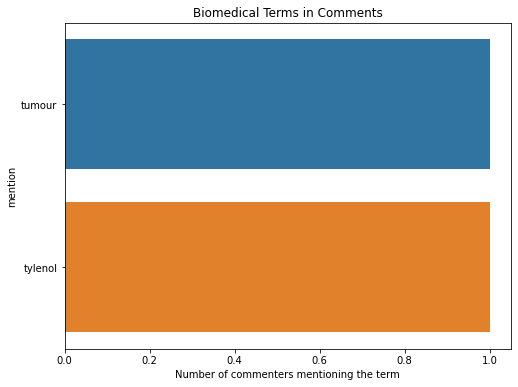

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the width and height of the figure
plt.figure(figsize=(8,6))

ax = sns.barplot(x=dfwords.dfi_idx, y=dfwords.mention)

#title
ax.set_title(f'Biomedical Terms in Comments')

# Add label for  axis
ax.set(xlabel='Number of commenters mentioning the term')